In [1]:
%cd ..

/home/cole/Documents/dl-final-project


In [2]:
import os
from time import perf_counter

import numpy as np
import torch

from data import get_unlabeled_set, get_labeled_set, \
    make_bounding_box_images, horz_flip_tensor, convert_bounding_box_targets
from model.resnet_fpn import ResnetFPN, MapReconstructor
from model.segmentation import SegmentationNetwork

import matplotlib.pyplot as plt

In [3]:
output_path = '../fpn_weights/'

unlabeled_batch_size = 32
labeled_batch_size = 4

unlabeled_epochs = 10
labeled_epochs = 10

In [4]:
_, unlabeled_trainloader = get_unlabeled_set(batch_size=unlabeled_batch_size)
(_, labeled_trainloader), (_, labeled_testloader) = get_labeled_set(batch_size=labeled_batch_size,
                                                                    validation=0.2)

==> Validation Index: 128


In [5]:
encoder = ResnetFPN()
obj_decoder = MapReconstructor(10, output_channels=2)
road_decoder = MapReconstructor(10, output_channels=2)
seg_model = SegmentationNetwork()

In [6]:
def load(m, file_name):
    file_path = os.path.join(output_path, file_name)
    m.load_state_dict(torch.load(file_path, map_location=torch.device('cpu')))

In [7]:
load(encoder, 'encoder-latest.torch')
load(obj_decoder, 'obj-decoder-latest.torch')
load(road_decoder, 'road-decoder-latest.torch')
load(seg_model, 'seg-latest.torch')

In [8]:
encoder = encoder.eval()
obj_decoder = obj_decoder.eval()
road_decoder = road_decoder.eval()
seg_model = seg_model.eval()

In [9]:
images, targets, road_map = iter(labeled_testloader).next()
image = images[0][None, ...]

In [10]:
enc = encoder(image)
obj_map_recon = obj_decoder.infer(enc)
road_map_recon = road_decoder.infer(enc)

In [11]:
bin_obj = torch.argmax(obj_map_recon[0], 0)
bin_road = torch.argmin(road_map_recon[0], 0)

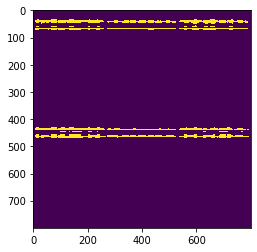

In [12]:
plt.imshow(bin_obj)

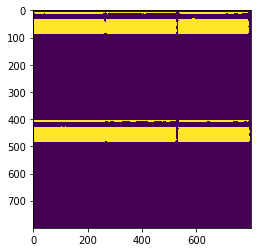

In [13]:
plt.imshow(bin_road)

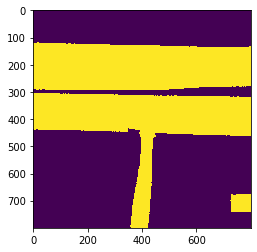

In [14]:
plt.imshow(road_map[0])

In [15]:
o = torch.sigmoid(obj_map_recon[:, 1, :, :].view(-1, 1, 800, 800))

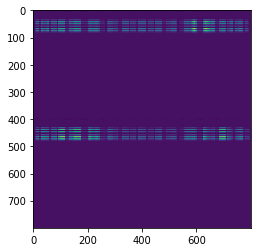

In [16]:
plt.imshow(o[0][0])

In [17]:
seg_model.segmentation_network(o)

RuntimeError: cannot reshape tensor of 0 elements into shape [0, -1] because the unspecified dimension size -1 can be any value and is ambiguous

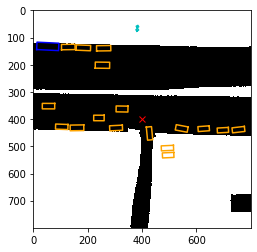

In [18]:
from helpers.helper import draw_box
# The center of image is 400 * 400
fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_map[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(targets[0]['bounding_box']):
    # You can check the implementation of the draw box to understand how it works
    draw_box(ax, bb, color=color_list[targets[0]['category'][i]])